In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, low_memory=False)
    df = reduce_mem_usage(df)

    return df

In [4]:
df = import_data("train_all.csv")

Memory usage of dataframe is 2459.86 MB
Memory usage after optimization is: 968.11 MB
Decreased by 60.6%


In [5]:
df_test = import_data("test_all.csv")
df_test.head()

Memory usage of dataframe is 112.10 MB
Memory usage after optimization is: 46.05 MB
Decreased by 58.9%


,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name
0,2021-07-31 00:00:02.035000+00:00,5323264,0,823,1106635517,721367415,55264030,97997774,650.000,260.0000,...,1,0.076904,0.003651,5.000000,5,5,2020,Yargıcı,1182,Elbise
1,2021-07-31 00:00:05.503000+00:00,18238989,1,968,1106636273,721367451,4032918,16332708,105.000,73.5000,...,0,0.000000,0.002827,4.378906,1,5,15508,TRENDYOL MAN,604,T-Shirt
2,2021-07-31 00:00:08.173000+00:00,13354100,1,346,1106635244,721367483,98066435,163202748,79.875,39.9375,...,0,0.000000,0.001260,4.500000,3,5,381,Ltb,581,Deniz Şortu
3,2021-07-31 00:00:10.850000+00:00,49613268,1,335931,1106634651,721367533,87599480,146668239,120.000,65.0000,...,8,0.727051,0.001929,4.070312,1,5,1027526,Meriche,597,Gömlek
4,2021-07-31 00:00:10.989000+00:00,7252871,1,201,1106637202,721367537,96509590,160768055,105.750,59.5000,...,47,0.238525,0.002970,3.941406,1,5,36426,Güneşkızı,604,T-Shirt


In [6]:
sub_data = pd.read_csv("data/test_data.csv")
sub_data
#id: user_id | product_content_id | order_parent_id

,id,expected
0,18115|87073974|726348863,NaN
1,27588|118753298|723169934,NaN
2,29165|35699988|724122443,NaN
3,29969|5893187|722342150,NaN
4,35107|93897418|723421057,NaN
...,...,...
7466,71083899|100019570|728638514,NaN
7467,71106534|35624085|725372928,NaN
7468,71115350|94438742|725291348,NaN
7469,71115350|100017676|725291348,NaN


In [7]:
df_user = pd.read_csv("data/user_demographics.csv")
df_user.head()

,user_id,birth_date,membership_date,gender
0,22013146,NaN,2019-05-09 11:11:17.413000+00:00,Bay
1,49707264,NaN,2020-12-19 18:32:16.240000+00:00,Bay
2,48146878,NaN,2020-11-28 12:26:46.870000+00:00,Bay
3,53528681,NaN,2021-02-01 13:16:24.117000+00:00,Bay
4,17523184,NaN,2018-09-30 22:07:07.623000+00:00,Bay


In [8]:
from datetime import datetime, timezone
now = datetime.now(timezone.utc)

In [9]:
df_user['new_tenure'] = now - pd.to_datetime(df_user['membership_date'], errors='coerce')
df_user['new_tenure'] = df_user['new_tenure'].astype("str")
df_user['tenure'] = df_user['new_tenure'].apply(lambda x: int(x[:x.find("days")]))
df_user.head()

,user_id,birth_date,membership_date,gender,new_tenure,tenure
0,22013146,NaN,2019-05-09 11:11:17.413000+00:00,Bay,1074 days 03:47:43.186058,1074
1,49707264,NaN,2020-12-19 18:32:16.240000+00:00,Bay,483 days 20:26:44.359058,483
2,48146878,NaN,2020-11-28 12:26:46.870000+00:00,Bay,505 days 02:32:13.729058,505
3,53528681,NaN,2021-02-01 13:16:24.117000+00:00,Bay,440 days 01:42:36.482058,440
4,17523184,NaN,2018-09-30 22:07:07.623000+00:00,Bay,1294 days 16:51:52.976058,1294


In [10]:
drop_cols = ["new_tenure", "birth_date", "membership_date"]
df_user.drop(drop_cols, axis=1, inplace=True)

In [11]:
df = df.merge(df_user, on="user_id", how="left")

In [12]:
train_0 = df[df.is_returned == 0]
train_1 = df[df.is_returned == 1]

In [13]:
#numeric olan değerleri z_score a veriyorum
z_score = zscore(train_0[['original_price', 'discounted_price', 'coupon_discount', "returnRate",
   "total_claim", "unresolved_claim", "unresolved_accepted_claim", "unresolvedclaim_percentage",
    "defective_returnRate", "review_rates_mean", "review_rates_min", "review_rates_max", "tenure"]])

In [14]:
train_0.shape

(9341481, 33)

In [15]:
abs_zscore = abs(z_score)
train_0 = train_0[(abs_zscore < 3).all(axis=1)]
train_0.shape

(7927629, 33)

In [16]:
df = pd.concat([train_0, train_1])
df.shape

(9288865, 33)

In [17]:
df["discount_ratio"] = df["discounted_price"] / df["original_price"]
df["discount_with_promotion"] = ((df["coupon_discount"] * -1) + (df["promotion_award_value"])).fillna(0) / 100
df["is_saved_card_trx"] = df["is_saved_card_trx"].replace({True: 1, False: 0})
df["has_coupon"] = df["coupon_id"].notna().astype(int)
df["used_promo"] = df["promotion_name"].notna().astype(int)
df["gender"] = df["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": 1, "kvkktalepsilindi": 1})

In [18]:
drop_cols = ["order_date", "coupon_id", "promotion_name", "discounted_price", 
             "promotion_award_value", "coupon_discount", "brand_name", "category_name"]

df.drop(drop_cols, axis=1, inplace=True)
df.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,review_rates_min,review_rates_max,brand_id,category_id,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo
0,3941815,0,4662,901280147,595758968,95503167,159147197,79.875,8.882812,0,...,1,5,682,604,1,4028,0.650391,0.350098,0,1
3,3941815,0,163,901280149,595758968,36313798,64622938,130.000,9.398438,0,...,1,5,121,604,1,4028,0.461182,0.399902,0,1
4,15996105,1,968,901279297,595758987,96930601,161408176,90.000,9.398438,0,...,2,5,40,1182,1,1458,0.799805,0.199951,0,1
5,11914979,1,968,901280115,595759022,80139132,135798900,57.000,1.342773,0,...,1,5,15508,530,1,2236,0.500000,0.500000,0,1
6,11914979,1,968,901280114,595759022,82581293,139386629,70.000,1.342773,0,...,2,5,15508,601,1,2236,0.399902,0.600098,0,1


In [19]:
df["ship_cost"].fillna(df["ship_cost"].median(), inplace=True)

In [20]:
with open("data/user_return_ratio.txt") as f:
    user_return_ratio = eval(f.read())

In [21]:
df["user_return_ratio"] = df["user_id"].apply(lambda x: user_return_ratio[x])

In [22]:
df.dropna(subset=['discount_ratio'], inplace=True)

In [23]:
df.shape

(9288863, 30)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(df.drop("is_returned", axis=1),
                                                df["is_returned"], test_size=0.2,
                                                  stratify=df["is_returned"], random_state=0)

In [25]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [26]:
def lgb_f1_score(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = np.where(y_pred >= 0.5, 1, 0).astype(int)
    return 'f1', f1_score(y_true, y_pred), True

In [30]:
def objective(trial):
    params = {
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),
        "num_leaves": trial.suggest_int("num_leaves", 2, 128),
        "n_estimators": trial.suggest_categorical("n_estimators", range(100, 500, 100)),
        "learning_rate": trial.suggest_float("learning_rate",  0.01, 0.3),
        
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
     
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)}


    model = LGBMClassifier(objective="binary", **params)
    model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric = lgb_f1_score,
            early_stopping_rounds=200)
    preds = model.predict(X_val)
    
    score = f1_score(y_val,preds)
    return score

In [31]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)

[I 2022-04-17 18:12:08,256] A new study created in memory with name: no-name-ace57631-a00a-40c9-9373-fa8b2c2014cd


[1]	valid_0's binary_logloss: 0.352159	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.308411	valid_0's f1: 8.08057e-05
[3]	valid_0's binary_logloss: 0.295795	valid_0's f1: 0.534499
[4]	valid_0's binary_logloss: 0.27537	valid_0's f1: 0.722737
[5]	valid_0's binary_logloss: 0.261296	valid_0's f1: 0.768194
[6]	valid_0's binary_logloss: 0.251724	valid_0's f1: 0.774723
[7]	valid_0's binary_logloss: 0.246701	valid_0's f1: 0.768574
[8]	valid_0's binary_logloss: 0.243692	valid_0's f1: 0.764062
[9]	valid_0's binary_logloss: 0.23779	valid_0's f1: 0.756632
[10]	valid_0's binary_logloss: 0.235805	valid_0's f1: 0.751689
[11]	valid_0's binary_logloss: 0.239271	valid_0's f1: 0.748888
[12]	valid_0's binary_logloss: 0.238992	valid_0's f1: 0.745254
[13]	valid_0's binary_logloss: 0.235014	valid_0's f1: 0.743098
[14]	valid_0's binary_logloss: 0.232888	valid_0's f1: 0.741949
[15]	valid_0's binary_logloss: 0.233037	valid_0's f1: 0.740238
[16]	valid_0's binary_logloss: 0.233277	valid_0's f1: 0.738147
[17]	va

[132]	valid_0's binary_logloss: 0.196251	valid_0's f1: 0.758083
[133]	valid_0's binary_logloss: 0.196008	valid_0's f1: 0.758208
[134]	valid_0's binary_logloss: 0.19598	valid_0's f1: 0.758267
[135]	valid_0's binary_logloss: 0.195885	valid_0's f1: 0.758365
[136]	valid_0's binary_logloss: 0.195877	valid_0's f1: 0.758352
[137]	valid_0's binary_logloss: 0.195873	valid_0's f1: 0.758324
[138]	valid_0's binary_logloss: 0.19586	valid_0's f1: 0.758348
[139]	valid_0's binary_logloss: 0.195829	valid_0's f1: 0.758347
[140]	valid_0's binary_logloss: 0.195778	valid_0's f1: 0.758473
[141]	valid_0's binary_logloss: 0.195742	valid_0's f1: 0.758478
[142]	valid_0's binary_logloss: 0.195729	valid_0's f1: 0.75848
[143]	valid_0's binary_logloss: 0.195702	valid_0's f1: 0.758508
[144]	valid_0's binary_logloss: 0.19565	valid_0's f1: 0.758573
[145]	valid_0's binary_logloss: 0.195616	valid_0's f1: 0.758643
[146]	valid_0's binary_logloss: 0.195597	valid_0's f1: 0.758676
[147]	valid_0's binary_logloss: 0.195569	val

[I 2022-04-17 18:17:31,915] Trial 0 finished with value: 0.7604325833215503 and parameters: {'is_unbalance': True, 'num_leaves': 71, 'n_estimators': 200, 'learning_rate': 0.15144774068547529, 'min_data_in_leaf': 2600, 'lambda_l1': 60, 'lambda_l2': 60, 'min_gain_to_split': 3.4566094618340126, 'bagging_fraction': 0.7, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.7604325833215503.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=6.872443345590439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.872443345590439
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[1]	valid_0's binary_logloss: 0.403031	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.387129	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.377021	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.364846	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.354085	valid_0's f1: 0
[6]

[I 2022-04-17 18:20:24,830] Trial 1 finished with value: 0.745432603266779 and parameters: {'is_unbalance': True, 'num_leaves': 128, 'n_estimators': 100, 'learning_rate': 0.026424561963060145, 'min_data_in_leaf': 4000, 'lambda_l1': 30, 'lambda_l2': 95, 'min_gain_to_split': 6.872443345590439, 'bagging_fraction': 0.5, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.745432603266779.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.238061142476901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.238061142476901
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[1]	valid_0's binary_logloss: 0.341432	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.311286	valid_0's f1: 0.158571
[3]	valid_0's binary_logloss: 0.30193	valid_0's f1: 0.206185
[4]	valid_0's binary_logloss: 0.282508	valid_0's f1: 0.352889
[5]	vali

[120]	valid_0's binary_logloss: 0.126274	valid_0's f1: 0.815084
[121]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.815084
[122]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.81508
[123]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.81508
[124]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.81509
[125]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.81509
[126]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.81509
[127]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.81509
[128]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[129]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[130]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[131]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[132]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[133]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[134]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[135]	valid_0's binary_logloss: 0.126272	valid_0's f1

[251]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[252]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[253]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[254]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[255]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[256]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[257]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[258]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[259]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[260]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[261]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[262]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[263]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[264]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[265]	valid_0's binary_logloss: 0.126272	valid_0's f1: 0.81509
[266]	valid_0's binary_logloss: 0.126272	valid_0's f1: 

[I 2022-04-17 18:26:40,031] Trial 2 finished with value: 0.8151220593357185 and parameters: {'is_unbalance': False, 'num_leaves': 120, 'n_estimators': 400, 'learning_rate': 0.24742410881241766, 'min_data_in_leaf': 200, 'lambda_l1': 30, 'lambda_l2': 85, 'min_gain_to_split': 7.238061142476901, 'bagging_fraction': 0.4, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.745432603266779.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=12.650427380220226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.650427380220226
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[1]	valid_0's binary_logloss: 0.369888	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.331435	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.317145	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.296766	valid_0's f1: 8.08057e-05
[5]	valid_0's binary_logloss: 0.285645	valid_0

[120]	valid_0's binary_logloss: 0.198924	valid_0's f1: 0.755358
[121]	valid_0's binary_logloss: 0.198868	valid_0's f1: 0.755404
[122]	valid_0's binary_logloss: 0.198746	valid_0's f1: 0.755633
[123]	valid_0's binary_logloss: 0.198728	valid_0's f1: 0.755608
[124]	valid_0's binary_logloss: 0.198688	valid_0's f1: 0.755602
[125]	valid_0's binary_logloss: 0.198527	valid_0's f1: 0.75573
[126]	valid_0's binary_logloss: 0.198384	valid_0's f1: 0.755892
[127]	valid_0's binary_logloss: 0.198342	valid_0's f1: 0.755993
[128]	valid_0's binary_logloss: 0.198259	valid_0's f1: 0.756026
[129]	valid_0's binary_logloss: 0.198241	valid_0's f1: 0.756062
[130]	valid_0's binary_logloss: 0.198172	valid_0's f1: 0.756217
[131]	valid_0's binary_logloss: 0.198124	valid_0's f1: 0.756328
[132]	valid_0's binary_logloss: 0.19804	valid_0's f1: 0.756473
[133]	valid_0's binary_logloss: 0.197773	valid_0's f1: 0.756687
[134]	valid_0's binary_logloss: 0.197743	valid_0's f1: 0.756717
[135]	valid_0's binary_logloss: 0.197618	v

[I 2022-04-17 18:32:06,420] Trial 3 finished with value: 0.7842997717410837 and parameters: {'is_unbalance': True, 'num_leaves': 102, 'n_estimators': 300, 'learning_rate': 0.10005353859605971, 'min_data_in_leaf': 3700, 'lambda_l1': 55, 'lambda_l2': 90, 'min_gain_to_split': 12.650427380220226, 'bagging_fraction': 0.2, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.745432603266779.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.28745402873037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.28745402873037
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[1]	valid_0's binary_logloss: 0.373224	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.315888	valid_0's f1: 0.00146084
[3]	valid_0's binary_logloss: 0.290777	valid_0's f1: 0.148326
[4]	valid_0's binary_logloss: 0.268145	valid_0's f1: 0.335044
[5]	valid_0's binary_logloss: 0.252114	vali

[120]	valid_0's binary_logloss: 0.126273	valid_0's f1: 0.815148
[121]	valid_0's binary_logloss: 0.1262	valid_0's f1: 0.815213
[122]	valid_0's binary_logloss: 0.126163	valid_0's f1: 0.815288
[123]	valid_0's binary_logloss: 0.126152	valid_0's f1: 0.815302
[124]	valid_0's binary_logloss: 0.126139	valid_0's f1: 0.815391
[125]	valid_0's binary_logloss: 0.12612	valid_0's f1: 0.815333
[126]	valid_0's binary_logloss: 0.126077	valid_0's f1: 0.815481
[127]	valid_0's binary_logloss: 0.126032	valid_0's f1: 0.815512
[128]	valid_0's binary_logloss: 0.125989	valid_0's f1: 0.815622
[129]	valid_0's binary_logloss: 0.125961	valid_0's f1: 0.815634
[130]	valid_0's binary_logloss: 0.125926	valid_0's f1: 0.815603
[131]	valid_0's binary_logloss: 0.125898	valid_0's f1: 0.815644
[132]	valid_0's binary_logloss: 0.125878	valid_0's f1: 0.81559
[133]	valid_0's binary_logloss: 0.125851	valid_0's f1: 0.815648
[134]	valid_0's binary_logloss: 0.125841	valid_0's f1: 0.815667
[135]	valid_0's binary_logloss: 0.125828	val

[I 2022-04-17 18:36:53,134] Trial 4 finished with value: 0.816246517457759 and parameters: {'is_unbalance': False, 'num_leaves': 52, 'n_estimators': 200, 'learning_rate': 0.1505450597187055, 'min_data_in_leaf': 600, 'lambda_l1': 0, 'lambda_l2': 0, 'min_gain_to_split': 7.28745402873037, 'bagging_fraction': 0.8, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.745432603266779.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=6.155236996753004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.155236996753004
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[1]	valid_0's binary_logloss: 0.360015	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.317873	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.303534	valid_0's f1: 0.00786618
[4]	valid_0's binary_logloss: 0.283331	valid_0's f1: 0.627882
[5]	valid_0's binary_logloss: 0.268831	val

[120]	valid_0's binary_logloss: 0.200395	valid_0's f1: 0.754736
[121]	valid_0's binary_logloss: 0.200306	valid_0's f1: 0.754773
[122]	valid_0's binary_logloss: 0.20023	valid_0's f1: 0.754902
[123]	valid_0's binary_logloss: 0.200189	valid_0's f1: 0.754937
[124]	valid_0's binary_logloss: 0.200093	valid_0's f1: 0.754999
[125]	valid_0's binary_logloss: 0.200049	valid_0's f1: 0.755023
[126]	valid_0's binary_logloss: 0.200029	valid_0's f1: 0.755019
[127]	valid_0's binary_logloss: 0.199989	valid_0's f1: 0.755075
[128]	valid_0's binary_logloss: 0.199872	valid_0's f1: 0.755197
[129]	valid_0's binary_logloss: 0.199838	valid_0's f1: 0.75525
[130]	valid_0's binary_logloss: 0.199805	valid_0's f1: 0.755293
[131]	valid_0's binary_logloss: 0.199764	valid_0's f1: 0.755269
[132]	valid_0's binary_logloss: 0.199703	valid_0's f1: 0.755356
[133]	valid_0's binary_logloss: 0.199605	valid_0's f1: 0.75545
[134]	valid_0's binary_logloss: 0.199514	valid_0's f1: 0.755551
[135]	valid_0's binary_logloss: 0.199355	va

[I 2022-04-17 18:42:11,604] Trial 5 finished with value: 0.7726650753606753 and parameters: {'is_unbalance': True, 'num_leaves': 47, 'n_estimators': 300, 'learning_rate': 0.12989153515874652, 'min_data_in_leaf': 3300, 'lambda_l1': 70, 'lambda_l2': 75, 'min_gain_to_split': 6.155236996753004, 'bagging_fraction': 0.7, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.745432603266779.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=12.111702305076719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.111702305076719
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[1]	valid_0's binary_logloss: 0.411528	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.405115	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.400277	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.394411	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.388852	valid_0's f1: 0
[

[I 2022-04-17 18:45:23,265] Trial 6 finished with value: 0.7065652812267759 and parameters: {'is_unbalance': False, 'num_leaves': 44, 'n_estimators': 100, 'learning_rate': 0.01170337485478, 'min_data_in_leaf': 9400, 'lambda_l1': 90, 'lambda_l2': 10, 'min_gain_to_split': 12.111702305076719, 'bagging_fraction': 0.5, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=5.34520824650018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.34520824650018
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[1]	valid_0's binary_logloss: 0.38294	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.349043	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.329733	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.308063	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.290388	valid_0's f1: 0
[6]	vali

[121]	valid_0's binary_logloss: 0.131139	valid_0's f1: 0.806837
[122]	valid_0's binary_logloss: 0.131023	valid_0's f1: 0.807
[123]	valid_0's binary_logloss: 0.130976	valid_0's f1: 0.807048
[124]	valid_0's binary_logloss: 0.130925	valid_0's f1: 0.807052
[125]	valid_0's binary_logloss: 0.130857	valid_0's f1: 0.807191
[126]	valid_0's binary_logloss: 0.130781	valid_0's f1: 0.807338
[127]	valid_0's binary_logloss: 0.130726	valid_0's f1: 0.807391
[128]	valid_0's binary_logloss: 0.130686	valid_0's f1: 0.807502
[129]	valid_0's binary_logloss: 0.13064	valid_0's f1: 0.807539
[130]	valid_0's binary_logloss: 0.13057	valid_0's f1: 0.807722
[131]	valid_0's binary_logloss: 0.130531	valid_0's f1: 0.807806
[132]	valid_0's binary_logloss: 0.130473	valid_0's f1: 0.807918
[133]	valid_0's binary_logloss: 0.13037	valid_0's f1: 0.808059
[134]	valid_0's binary_logloss: 0.130297	valid_0's f1: 0.808089
[135]	valid_0's binary_logloss: 0.130275	valid_0's f1: 0.808132
[136]	valid_0's binary_logloss: 0.130238	valid

[I 2022-04-17 18:51:49,756] Trial 7 finished with value: 0.8121989480118452 and parameters: {'is_unbalance': False, 'num_leaves': 46, 'n_estimators': 200, 'learning_rate': 0.07815283457644107, 'min_data_in_leaf': 4800, 'lambda_l1': 65, 'lambda_l2': 5, 'min_gain_to_split': 5.34520824650018, 'bagging_fraction': 0.2, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=9.68099401847181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.68099401847181
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[1]	valid_0's binary_logloss: 0.371246	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.345134	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.336575	valid_0's f1: 0.0243395
[4]	valid_0's binary_logloss: 0.317236	valid_0's f1: 0.138985
[5]	valid_0

[120]	valid_0's binary_logloss: 0.127492	valid_0's f1: 0.813828
[121]	valid_0's binary_logloss: 0.127473	valid_0's f1: 0.813907
[122]	valid_0's binary_logloss: 0.127451	valid_0's f1: 0.813924
[123]	valid_0's binary_logloss: 0.127441	valid_0's f1: 0.813929
[124]	valid_0's binary_logloss: 0.12742	valid_0's f1: 0.813959
[125]	valid_0's binary_logloss: 0.127416	valid_0's f1: 0.813967
[126]	valid_0's binary_logloss: 0.127414	valid_0's f1: 0.813996
[127]	valid_0's binary_logloss: 0.127361	valid_0's f1: 0.813968
[128]	valid_0's binary_logloss: 0.127347	valid_0's f1: 0.814014
[129]	valid_0's binary_logloss: 0.12728	valid_0's f1: 0.814266
[130]	valid_0's binary_logloss: 0.127237	valid_0's f1: 0.8143
[131]	valid_0's binary_logloss: 0.127219	valid_0's f1: 0.814308
[132]	valid_0's binary_logloss: 0.127218	valid_0's f1: 0.814291
[133]	valid_0's binary_logloss: 0.127213	valid_0's f1: 0.81428
[134]	valid_0's binary_logloss: 0.12721	valid_0's f1: 0.814323
[135]	valid_0's binary_logloss: 0.127189	valid

[I 2022-04-17 18:59:39,985] Trial 8 finished with value: 0.8144198804342022 and parameters: {'is_unbalance': False, 'num_leaves': 123, 'n_estimators': 200, 'learning_rate': 0.14075783716250706, 'min_data_in_leaf': 1600, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 9.68099401847181, 'bagging_fraction': 0.7, 'feature_fraction': 0.30000000000000004}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] min_gain_to_split is set=10.237875057787976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.237875057787976
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[1]	valid_0's binary_logloss: 0.342919	valid_0's f1: 0.168951
[2]	valid_0's binary_logloss: 0.293507	valid_0's f1: 0.708132
[3]	valid_0's binary_logloss: 0.287515	valid_0's f1: 0.738758
[4]	valid_0's binary_logloss: 0.268769	valid_0's f1: 0.74841

[120]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[121]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[122]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[123]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[124]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[125]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[126]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[127]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[128]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[129]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[130]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[131]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[132]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[133]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[134]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[135]	valid_0's binary_logloss: 0.196966

[249]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[250]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[251]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[252]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[253]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[254]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[255]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[256]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[257]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[258]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[259]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[260]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[261]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[262]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[263]	valid_0's binary_logloss: 0.196966	valid_0's f1: 0.758403
[264]	valid_0's binary_logloss: 0.196966

[I 2022-04-17 20:53:20,993] Trial 9 finished with value: 0.7584029244196021 and parameters: {'is_unbalance': True, 'num_leaves': 111, 'n_estimators': 400, 'learning_rate': 0.2746811299048963, 'min_data_in_leaf': 8500, 'lambda_l1': 75, 'lambda_l2': 70, 'min_gain_to_split': 10.237875057787976, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.4}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=14.96540730798653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.96540730798653
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[1]	valid_0's binary_logloss: 0.344887	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.287036	valid_0's f1: 0.331844
[3]	valid_0's binary_logloss: 0.265181	valid_0's f1: 0.534882
[4]	valid_0's binary_logloss: 0.238022	valid_0's f1: 0.593331
[5]	valid_0's binary_logloss: 0.219

[I 2022-04-17 20:55:41,522] Trial 10 finished with value: 0.801599717696877 and parameters: {'is_unbalance': False, 'num_leaves': 12, 'n_estimators': 100, 'learning_rate': 0.21237255997243543, 'min_data_in_leaf': 9400, 'lambda_l1': 100, 'lambda_l2': 30, 'min_gain_to_split': 14.96540730798653, 'bagging_fraction': 0.4, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=1.9961068632046706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9961068632046706
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[1]	valid_0's binary_logloss: 0.403484	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.387729	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.377743	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.365755	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.355107	valid_0's f1: 0
[

[I 2022-04-17 20:58:28,982] Trial 11 finished with value: 0.7409176346419528 and parameters: {'is_unbalance': True, 'num_leaves': 81, 'n_estimators': 100, 'learning_rate': 0.026218379993570295, 'min_data_in_leaf': 7000, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 1.9961068632046706, 'bagging_fraction': 0.4, 'feature_fraction': 0.7}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=0.0943679615027262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0943679615027262
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[1]	valid_0's binary_logloss: 0.403821	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.388628	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.379191	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.367375	valid_0's f1: 0
[5]	valid_0's binary_loglo

[I 2022-04-17 21:01:18,255] Trial 12 finished with value: 0.7410230091015889 and parameters: {'is_unbalance': True, 'num_leaves': 80, 'n_estimators': 100, 'learning_rate': 0.025553166997339942, 'min_data_in_leaf': 7100, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 0.0943679615027262, 'bagging_fraction': 0.4, 'feature_fraction': 0.6000000000000001}. Best is trial 6 with value: 0.7065652812267759.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=1.539962601460246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.539962601460246
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[1]	valid_0's binary_logloss: 0.411911	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.405798	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.401291	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.395736	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.390426	valid_0's f1: 0
[

[I 2022-04-17 21:03:42,179] Trial 13 finished with value: 0.6667154964452708 and parameters: {'is_unbalance': False, 'num_leaves': 21, 'n_estimators': 100, 'learning_rate': 0.01155129841094557, 'min_data_in_leaf': 6400, 'lambda_l1': 100, 'lambda_l2': 30, 'min_gain_to_split': 1.539962601460246, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}. Best is trial 13 with value: 0.6667154964452708.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=10.13226228500354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.13226228500354
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[1]	valid_0's binary_logloss: 0.387456	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.356883	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.339733	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.319077	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.302059	valid_0's f1: 0
[

[I 2022-04-17 21:06:41,027] Trial 14 finished with value: 0.7916887626634612 and parameters: {'is_unbalance': False, 'num_leaves': 18, 'n_estimators': 100, 'learning_rate': 0.07192971889063876, 'min_data_in_leaf': 6400, 'lambda_l1': 100, 'lambda_l2': 15, 'min_gain_to_split': 10.13226228500354, 'bagging_fraction': 0.9, 'feature_fraction': 0.9}. Best is trial 13 with value: 0.6667154964452708.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=13.206062099092092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.206062099092092
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[1]	valid_0's binary_logloss: 0.343191	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.286164	valid_0's f1: 0.221887
[3]	valid_0's binary_logloss: 0.263022	valid_0's f1: 0.519053
[4]	valid_0's binary_logloss: 0.236423	valid_0's f1: 0.600272
[5]	valid_0's binary_logloss: 0.217

[I 2022-04-17 21:09:44,283] Trial 15 finished with value: 0.8079909462185701 and parameters: {'is_unbalance': False, 'num_leaves': 28, 'n_estimators': 100, 'learning_rate': 0.19915930814608296, 'min_data_in_leaf': 9900, 'lambda_l1': 85, 'lambda_l2': 45, 'min_gain_to_split': 13.206062099092092, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}. Best is trial 13 with value: 0.6667154964452708.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] min_gain_to_split is set=3.9017513168012172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9017513168012172
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[1]	valid_0's binary_logloss: 0.407698	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.396124	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.388432	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.378864	valid_0's f1: 0
[5]	valid_0's binary_log

[I 2022-04-17 21:12:12,876] Trial 16 finished with value: 0.6487093299137106 and parameters: {'is_unbalance': False, 'num_leaves': 2, 'n_estimators': 100, 'learning_rate': 0.06235983736036688, 'min_data_in_leaf': 8500, 'lambda_l1': 85, 'lambda_l2': 15, 'min_gain_to_split': 3.9017513168012172, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.6487093299137106.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=3.630537666719726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.630537666719726
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[1]	valid_0's binary_logloss: 0.408947	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.398944	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.392173	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.383707	valid_0's f1: 0
[5]	valid_0's binary_loglo

[I 2022-04-17 21:14:33,989] Trial 17 finished with value: 0.6197130827041094 and parameters: {'is_unbalance': False, 'num_leaves': 2, 'n_estimators': 100, 'learning_rate': 0.0534300085525398, 'min_data_in_leaf': 5900, 'lambda_l1': 85, 'lambda_l2': 20, 'min_gain_to_split': 3.630537666719726, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.7}. Best is trial 17 with value: 0.6197130827041094.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=4.311562201270597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.311562201270597
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[1]	valid_0's binary_logloss: 0.390655	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.36136	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.346036	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.326363	valid_0's f1: 0
[5]	valid_0's binary_loglos

[120]	valid_0's binary_logloss: 0.153868	valid_0's f1: 0.771285
[121]	valid_0's binary_logloss: 0.153775	valid_0's f1: 0.771344
[122]	valid_0's binary_logloss: 0.153673	valid_0's f1: 0.771474
[123]	valid_0's binary_logloss: 0.153588	valid_0's f1: 0.771533
[124]	valid_0's binary_logloss: 0.1535	valid_0's f1: 0.771615
[125]	valid_0's binary_logloss: 0.153414	valid_0's f1: 0.771639
[126]	valid_0's binary_logloss: 0.153305	valid_0's f1: 0.77212
[127]	valid_0's binary_logloss: 0.15321	valid_0's f1: 0.77219
[128]	valid_0's binary_logloss: 0.153131	valid_0's f1: 0.772333
[129]	valid_0's binary_logloss: 0.153041	valid_0's f1: 0.772461
[130]	valid_0's binary_logloss: 0.152915	valid_0's f1: 0.772638
[131]	valid_0's binary_logloss: 0.152852	valid_0's f1: 0.77274
[132]	valid_0's binary_logloss: 0.152777	valid_0's f1: 0.772787
[133]	valid_0's binary_logloss: 0.152704	valid_0's f1: 0.772827
[134]	valid_0's binary_logloss: 0.15263	valid_0's f1: 0.772905
[135]	valid_0's binary_logloss: 0.152561	valid_

[249]	valid_0's binary_logloss: 0.146202	valid_0's f1: 0.784968
[250]	valid_0's binary_logloss: 0.146182	valid_0's f1: 0.785032
[251]	valid_0's binary_logloss: 0.146123	valid_0's f1: 0.785166
[252]	valid_0's binary_logloss: 0.146094	valid_0's f1: 0.785252
[253]	valid_0's binary_logloss: 0.146063	valid_0's f1: 0.785296
[254]	valid_0's binary_logloss: 0.145977	valid_0's f1: 0.785437
[255]	valid_0's binary_logloss: 0.14595	valid_0's f1: 0.785524
[256]	valid_0's binary_logloss: 0.145929	valid_0's f1: 0.785554
[257]	valid_0's binary_logloss: 0.145907	valid_0's f1: 0.785629
[258]	valid_0's binary_logloss: 0.145852	valid_0's f1: 0.785778
[259]	valid_0's binary_logloss: 0.145833	valid_0's f1: 0.785845
[260]	valid_0's binary_logloss: 0.145755	valid_0's f1: 0.785975
[261]	valid_0's binary_logloss: 0.145718	valid_0's f1: 0.786037
[262]	valid_0's binary_logloss: 0.145694	valid_0's f1: 0.786119
[263]	valid_0's binary_logloss: 0.145675	valid_0's f1: 0.786102
[264]	valid_0's binary_logloss: 0.145602	

[I 2022-04-17 21:24:27,124] Trial 18 finished with value: 0.7879012297558029 and parameters: {'is_unbalance': False, 'num_leaves': 5, 'n_estimators': 300, 'learning_rate': 0.08433583332089355, 'min_data_in_leaf': 8200, 'lambda_l1': 80, 'lambda_l2': 20, 'min_gain_to_split': 4.311562201270597, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.5}. Best is trial 17 with value: 0.6197130827041094.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=3.3608144721181548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3608144721181548
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[1]	valid_0's binary_logloss: 0.403161	valid_0's f1: 0
[2]	valid_0's binary_logloss: 0.399066	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.38484	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.372199	valid_0's f1: 0
[5]	valid_0's binary_logl

[120]	valid_0's binary_logloss: 0.171692	valid_0's f1: 0.751557
[121]	valid_0's binary_logloss: 0.171578	valid_0's f1: 0.751611
[122]	valid_0's binary_logloss: 0.171388	valid_0's f1: 0.751814
[123]	valid_0's binary_logloss: 0.171269	valid_0's f1: 0.752
[124]	valid_0's binary_logloss: 0.171091	valid_0's f1: 0.752308
[125]	valid_0's binary_logloss: 0.17098	valid_0's f1: 0.752467
[126]	valid_0's binary_logloss: 0.170838	valid_0's f1: 0.752857
[127]	valid_0's binary_logloss: 0.170657	valid_0's f1: 0.753209
[128]	valid_0's binary_logloss: 0.169962	valid_0's f1: 0.754152
[129]	valid_0's binary_logloss: 0.169841	valid_0's f1: 0.754431
[130]	valid_0's binary_logloss: 0.169761	valid_0's f1: 0.754514
[131]	valid_0's binary_logloss: 0.169652	valid_0's f1: 0.754842
[132]	valid_0's binary_logloss: 0.169482	valid_0's f1: 0.755077
[133]	valid_0's binary_logloss: 0.169389	valid_0's f1: 0.7553
[134]	valid_0's binary_logloss: 0.169045	valid_0's f1: 0.755752
[135]	valid_0's binary_logloss: 0.168946	valid

[249]	valid_0's binary_logloss: 0.154217	valid_0's f1: 0.77569
[250]	valid_0's binary_logloss: 0.154009	valid_0's f1: 0.775841
[251]	valid_0's binary_logloss: 0.153981	valid_0's f1: 0.775888
[252]	valid_0's binary_logloss: 0.153928	valid_0's f1: 0.776004
[253]	valid_0's binary_logloss: 0.153896	valid_0's f1: 0.776048
[254]	valid_0's binary_logloss: 0.153859	valid_0's f1: 0.776121
[255]	valid_0's binary_logloss: 0.153835	valid_0's f1: 0.776173
[256]	valid_0's binary_logloss: 0.153814	valid_0's f1: 0.776221
[257]	valid_0's binary_logloss: 0.153618	valid_0's f1: 0.776401
[258]	valid_0's binary_logloss: 0.153595	valid_0's f1: 0.776443
[259]	valid_0's binary_logloss: 0.153548	valid_0's f1: 0.776611
[260]	valid_0's binary_logloss: 0.153511	valid_0's f1: 0.776601
[261]	valid_0's binary_logloss: 0.153466	valid_0's f1: 0.776681
[262]	valid_0's binary_logloss: 0.153279	valid_0's f1: 0.776785
[263]	valid_0's binary_logloss: 0.153257	valid_0's f1: 0.776793
[264]	valid_0's binary_logloss: 0.153182	

[378]	valid_0's binary_logloss: 0.147765	valid_0's f1: 0.783474
[379]	valid_0's binary_logloss: 0.14775	valid_0's f1: 0.783566
[380]	valid_0's binary_logloss: 0.147708	valid_0's f1: 0.783486
[381]	valid_0's binary_logloss: 0.147696	valid_0's f1: 0.783519
[382]	valid_0's binary_logloss: 0.147654	valid_0's f1: 0.783551
[383]	valid_0's binary_logloss: 0.147634	valid_0's f1: 0.783537
[384]	valid_0's binary_logloss: 0.147614	valid_0's f1: 0.783596
[385]	valid_0's binary_logloss: 0.147575	valid_0's f1: 0.783626
[386]	valid_0's binary_logloss: 0.147559	valid_0's f1: 0.783692
[387]	valid_0's binary_logloss: 0.147502	valid_0's f1: 0.78385
[388]	valid_0's binary_logloss: 0.147481	valid_0's f1: 0.783915
[389]	valid_0's binary_logloss: 0.147445	valid_0's f1: 0.783913
[390]	valid_0's binary_logloss: 0.147418	valid_0's f1: 0.783978
[391]	valid_0's binary_logloss: 0.147404	valid_0's f1: 0.784019
[392]	valid_0's binary_logloss: 0.147386	valid_0's f1: 0.78405
[393]	valid_0's binary_logloss: 0.147349	va

[I 2022-04-17 22:35:24,350] Trial 19 finished with value: 0.7844244631047039 and parameters: {'is_unbalance': False, 'num_leaves': 5, 'n_estimators': 400, 'learning_rate': 0.055854558292460624, 'min_data_in_leaf': 5300, 'lambda_l1': 40, 'lambda_l2': 50, 'min_gain_to_split': 3.3608144721181548, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.2}. Best is trial 17 with value: 0.6197130827041094.


In [32]:
best_params = study.best_params
best_params

{'is_unbalance': False,
 'num_leaves': 2,
 'n_estimators': 100,
 'learning_rate': 0.0534300085525398,
 'min_data_in_leaf': 5900,
 'lambda_l1': 85,
 'lambda_l2': 20,
 'min_gain_to_split': 3.630537666719726,
 'bagging_fraction': 0.30000000000000004,
 'feature_fraction': 0.7}

In [33]:
study.best_trial

FrozenTrial(number=17, values=[0.6197130827041094], datetime_start=datetime.datetime(2022, 4, 17, 21, 12, 12, 878186), datetime_complete=datetime.datetime(2022, 4, 17, 21, 14, 33, 988080), params={'is_unbalance': False, 'num_leaves': 2, 'n_estimators': 100, 'learning_rate': 0.0534300085525398, 'min_data_in_leaf': 5900, 'lambda_l1': 85, 'lambda_l2': 20, 'min_gain_to_split': 3.630537666719726, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.7}, distributions={'is_unbalance': CategoricalDistribution(choices=(True, False)), 'num_leaves': IntUniformDistribution(high=128, low=2, step=1), 'n_estimators': CategoricalDistribution(choices=(100, 200, 300, 400)), 'learning_rate': UniformDistribution(high=0.3, low=0.01), 'min_data_in_leaf': IntUniformDistribution(high=10000, low=200, step=100), 'lambda_l1': IntUniformDistribution(high=100, low=0, step=5), 'lambda_l2': IntUniformDistribution(high=100, low=0, step=5), 'min_gain_to_split': UniformDistribution(high=15.0, low=0.0), 'baggi

In [35]:
best_model = LGBMClassifier(random_state=0, **best_params)

In [36]:
best_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=3.630537666719726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.630537666719726
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


LGBMClassifier(bagging_fraction=0.30000000000000004, feature_fraction=0.7,
               is_unbalance=False, lambda_l1=85, lambda_l2=20,
               learning_rate=0.0534300085525398, min_data_in_leaf=5900,
               min_gain_to_split=3.630537666719726, num_leaves=2,
               random_state=0)

In [37]:
best_model_pred = best_model.predict(X_val)

print("f1 binary:", f1_score(y_val, best_model_pred))
print(confusion_matrix(y_val, best_model_pred))
print(classification_report(y_val, best_model_pred))

f1 binary: 0.6197272705182214
[[1545360   40166]
 [ 131977  140270]]
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95   1585526
         1.0       0.78      0.52      0.62    272247

    accuracy                           0.91   1857773
   macro avg       0.85      0.74      0.78   1857773
weighted avg       0.90      0.91      0.90   1857773



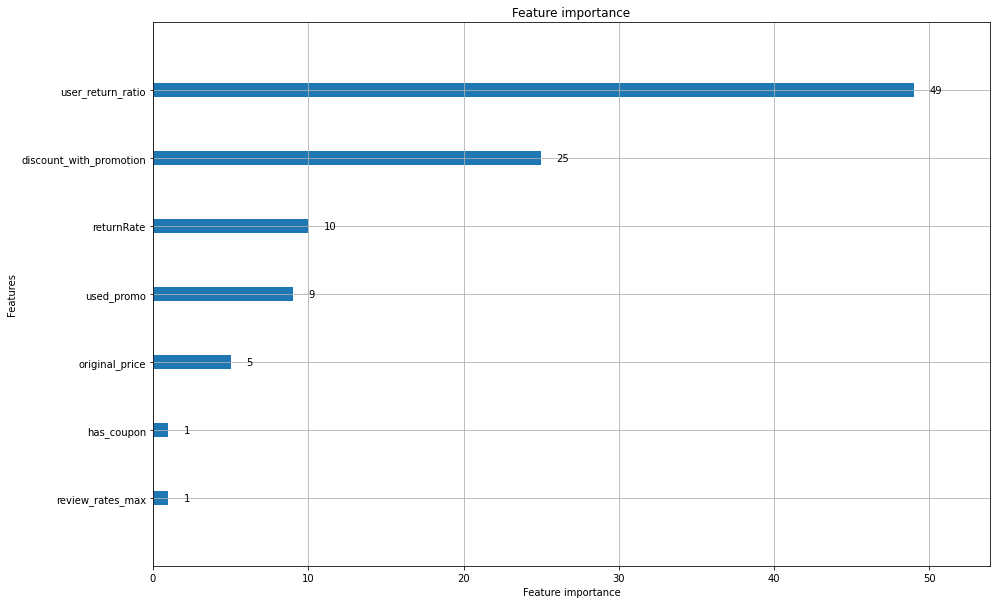

In [39]:
plot_importance(best_model, figsize=(15, 10));

### Preparing Submission File for LGBM Model

In [40]:
df_test = df_test.merge(df_user, on="user_id", how="left")

In [41]:
df_test["discount_ratio"] = df_test["discounted_price"] / df_test["original_price"]
df_test["discount_with_promotion"] = ((df_test["coupon_discount"] * -1) + (df_test["promotion_award_value"])).fillna(0) / 100
df_test["has_coupon"] = df_test["coupon_id"].notna().astype(int)
df_test["used_promo"] = df_test["promotion_name"].notna().astype(int)
df_test["user_return_ratio"] = df_test["user_id"].apply(lambda x: user_return_ratio[x])
df_test["is_saved_card_trx"] = df_test["is_saved_card_trx"].replace({True: 1, False: 0})
df_test["gender"] = df_test["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": 1, "kvkktalepsilindi": 1})

In [42]:
df_test.drop(drop_cols, axis=1, inplace=True)
df_test.shape

(487745, 30)

In [45]:
test_preds = best_model.predict(df_test[X_train.columns])
df_test["expected"] = test_preds
df_test.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,brand_id,category_id,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo,user_return_ratio,expected
0,5323264,0,823,1106635517,721367415,55264030,97997774,650.000,8.882812,0,...,2020,1182,1,3850,0.399902,0.000000,0,0,0.842105,1.0
1,18238989,1,968,1106636273,721367451,4032918,16332708,105.000,9.398438,1,...,15508,604,1,1251,0.700195,0.300049,0,1,0.000000,0.0
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.875,10.671875,0,...,381,581,1,1852,0.500000,0.000000,0,0,0.299213,1.0
3,49613268,1,335931,1106634651,721367533,87599480,146668239,120.000,11.328125,0,...,1027526,597,1,485,0.541504,0.399902,0,1,0.000000,0.0
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.750,8.882812,0,...,36426,604,1,3685,0.562500,0.250000,0,1,0.089286,0.0


In [46]:
df_test = df_test.groupby(by=["user_id" , "product_content_id" , "order_parent_id"])["expected"].max().reset_index()

In [47]:
sub_data[["user_id" , "product_content_id" , "order_parent_id"]] = sub_data["id"].str.split("|", expand=True)
sub_data = sub_data[["user_id" , "product_content_id" , "order_parent_id"]].astype(int)
sub_data.head()

,user_id,product_content_id,order_parent_id
0,18115,87073974,726348863
1,27588,118753298,723169934
2,29165,35699988,724122443
3,29969,5893187,722342150
4,35107,93897418,723421057


In [48]:
sub_final = sub_data.merge(df_test, on=["user_id" , "product_content_id" , "order_parent_id"], how="left")
sub_final.expected = sub_final.expected.astype(int)
sub_final.head()

,user_id,product_content_id,order_parent_id,expected
0,18115,87073974,726348863,0
1,27588,118753298,723169934,1
2,29165,35699988,724122443,0
3,29969,5893187,722342150,0
4,35107,93897418,723421057,0


In [49]:
sub_final["id"] = sub_final.apply(lambda x: str(x.user_id) + "|" + 
                                  str(x.product_content_id) + "|" + 
                                  str(x.order_parent_id), axis=1)

sub_final.head()

,user_id,product_content_id,order_parent_id,expected,id
0,18115,87073974,726348863,0,18115|87073974|726348863
1,27588,118753298,723169934,1,27588|118753298|723169934
2,29165,35699988,724122443,0,29165|35699988|724122443
3,29969,5893187,722342150,0,29969|5893187|722342150
4,35107,93897418,723421057,0,35107|93897418|723421057


In [50]:
sub_final.expected.value_counts(normalize=True)

0    0.924107
1    0.075893
Name: expected, dtype: float64

In [52]:
sub_final[["id", "expected"]].to_csv("sub_file_1704_hyperparameter_tune.csv", index=False)

In [ ]:
sub_final[["id", "expected"]]

### XGBoost Model

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# fit xgboost model
model_xgb = XGBClassifier(random_state=0)
model_xgb.fit(X_train, y_train)

In [ ]:
preds_xgb = model_xgb.predict(X_val)

print(confusion_matrix(y_val, preds_xgb))
print(classification_report(y_val, preds_xgb))

In [ ]:
f1_score(y_val, preds_xgb, average='binary')

### Preparing Submission File for XGBoost Model

In [ ]:
df_test_xgb = import_data("test_all.csv")

In [ ]:
df_test_xgb = df_test_xgb.merge(df_user, on="user_id", how="left")
df_test_xgb["discount_ratio"] = df_test_xgb["discounted_price"] / df_test_xgb["original_price"]
df_test_xgb["discount_with_promotion"] = ((df_test_xgb["coupon_discount"] * -1) + (df_test_xgb["promotion_award_value"])).fillna(0) / 100
df_test_xgb["has_coupon"] = df_test_xgb["coupon_id"].notna().astype(int)
df_test_xgb["used_promo"] = df_test_xgb["promotion_name"].notna().astype(int)
df_test_xgb["user_return_ratio"] = df_test_xgb["user_id"].apply(lambda x: user_return_ratio[x])
df_test_xgb["is_saved_card_trx"] = df_test_xgb["is_saved_card_trx"].replace({True: 1, False: 0})
df_test_xgb["gender"] = df_test_xgb["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": 1, "kvkktalepsilindi": 1})

In [ ]:
df_test_xgb.drop(drop_cols, axis=1, inplace=True)
df_test_xgb.shape

In [ ]:
test_preds_xgb = model_xgb.predict(df_test_xgb[X_train.columns])
df_test_xgb["expected"] = test_preds_xgb
df_test_xgb.head()

In [ ]:
df_test_xgb = df_test_xgb.groupby(by=["user_id" , "product_content_id" , "order_parent_id"])["expected"].max().reset_index()

In [ ]:
sub_data_xgb = pd.read_csv("data/test_data.csv")

In [ ]:
sub_data_xgb[["user_id" , "product_content_id" , "order_parent_id"]] = sub_data_xgb["id"].str.split("|", expand=True)
sub_data_xgb = sub_data_xgb[["user_id" , "product_content_id" , "order_parent_id"]].astype(int)
sub_data_xgb.head()

In [ ]:
sub_final_xgb = sub_data_xgb.merge(df_test_xgb, on=["user_id" , "product_content_id" , "order_parent_id"], how="left")
sub_final_xgb.expected = sub_final_xgb.expected.astype(int)
sub_final_xgb.head()

In [ ]:
sub_final_xgb["id"] = sub_final_xgb.apply(lambda x: str(x.user_id) + "|" + 
                                  str(x.product_content_id) + "|" + 
                                  str(x.order_parent_id), axis=1)

sub_final_xgb.head()

In [ ]:
sub_final_xgb.expected.value_counts(normalize=True)

In [ ]:
sub_final_xgb[["id", "expected"]].to_csv("sub_file_1704_xgboost.csv", index=False)